In [1]:
# Imports
import torch
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
import pygame
import random
import tqdm

In [2]:
# While training neural networks, we split the data into batches.
# To improve the training, we need to remove the "correlation" between game states
# The buffer starts storing states and once it reaches maximum capacity, it replaces
# states at random which reduces the correlation.
class chaser_ExperienceBuffer:
    def __init__(self, capacity):

        self.buffer = torch.zeros(size=(capacity, 2), dtype=torch.float)
        self.actions = torch.zeros(size=(capacity, 1), dtype=torch.long)
        # self.next_actions = torch.zeros(size=(capacity, 1), dtype=torch.long)
        self.buffer_states = torch.zeros(size=(capacity, 10), dtype=torch.float)
        self.buffer_nextstates = torch.zeros(size=(capacity, 10), dtype=torch.float)

        # total samples collected
        self.occupied = 0

        self.cap = capacity

    
    def push(self, state, action, reward, next_state, done):  
        
        if self.occupied < self.cap:
            index = self.occupied
        else:
            # after being filled replacing randomly
            index = np.random.randint(low =0, high=self.occupied)

        self.buffer[index][0] = reward
        self.buffer[index][1] = done

        self.actions[index] = action
        self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
        self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
        
        self.occupied += 1
        self.occupied = min(self.occupied, self.cap)

    def sample(self, batch_size):

        batch = torch.randint(0, self.occupied, size=(batch_size,))

        return self.buffer[batch], self.actions[batch], self.buffer_states[batch], self.buffer_nextstates[batch]
    
    def filled(self, batch):
        
        return self.occupied >= batch 



In [54]:
class ChaseEscapeEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, render_mode=None):
        super().__init__()

        self.dt = 0.1
        self.max_speed = 0.4
        self.agent_radius = 0.05
        self.target_radius = 0.05
        self.chaser_radius = 0.07
        self.chaser_speed = 0.03


        self.action_space = gym.spaces.MultiDiscrete([3, 3])  # actions in {0,1,2} map to [-1,0,1]
        self.observation_space = gym.spaces.Box(
            low=-1,
            high=1,
            shape=(10,),
            dtype=np.float32,
        )

        self.render_mode = render_mode
        self.screen_size = 500
        self.np_random = None

        if render_mode == "human":
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))
            self.clock = pygame.time.Clock()

    def sample_pos(self, far_from=None, min_dist=0.5):
        while True:
            pos = self.np_random.uniform(low=-0.8, high=0.8, size=(2,))
            if far_from is None or np.linalg.norm(pos - far_from) >= min_dist:
                return pos

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.agent_pos = self.sample_pos()
        self.agent_vel = np.zeros(2, dtype=np.float32)
        self.target_vel = 2*np.random.rand(2,) - 1
        self.target_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.5)
        self.chaser_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.7)

        dist_to_target = np.linalg.norm(self.agent_pos - self.target_pos)
        dist_to_chaser = np.linalg.norm(self.agent_pos - self.chaser_pos)

        return self._get_obs(dist_to_chaser, dist_to_target), {}

    def _get_obs(self, chaser_dist, target_dist):
        # TODO: Decide how to pass the state (don't use pixel values)
        
        obs = torch.zeros(size=(10,))

        obs[7] = chaser_dist/2
        obs[8], obs[9] = (self.chaser_pos - self.agent_pos)/chaser_dist

        obs[0] = target_dist/2
        obs[1], obs[2] = (self.target_pos - self.agent_pos)/target_dist

        obs[3], obs[4] = abs(self.agent_pos[0]), abs(self.agent_pos[1])
        obs[5], obs[6] = torch.tensor(self.agent_vel, dtype=torch.float)

        return obs

    def _get_info(self):
        return {}

    def step(self, action):
        # TODO: Add reward scheme
        # 1) Try to make the agent stay within bounds
        # 2) The agent shouldn't idle around
        # 3) The agent should go for the reward
        # 4) The agent should avoid the chaser

        reward = 0.0


        accel = (np.array(action) - 1) * 0.1
        self.agent_vel += accel
        self.agent_vel = np.clip(self.agent_vel, -self.max_speed, self.max_speed)
        self.agent_pos += self.agent_vel * self.dt
        self.agent_pos = np.clip(self.agent_pos, -1, 1)

        # self.target_pos += self.target_vel*self.dt
        
        if abs(self.target_pos[1]) >= 1 or abs(self.target_pos[0]) >= 1:
            self.target_vel = 2*np.random.rand(2,) - 1
        
        self.target_pos = np.clip(self.target_pos, -1, 1)
        


        if abs(self.agent_pos[0]) >= 0.8:
            reward -= abs(self.agent_pos[0]) - 0.8
        
        if abs(self.agent_pos[1]) >= 0.8:
            reward -= abs(self.agent_pos[1]) - 0.8

            

        direction = self.agent_pos - self.chaser_pos
        norm = np.linalg.norm(direction)
        if norm > 1e-5:
            self.chaser_pos += self.chaser_speed * direction / norm

        dist_to_target = np.linalg.norm(self.agent_pos - self.target_pos)
        # dist_to_chaser = np.linalg.norm(self.agent_pos - self.chaser_pos)
        dist_to_chaser = norm

        terminated = False
        reward -= 0.1

        # if dist_to_target < dist_to_chaser:
            # reward += 1
        reward += 1 - dist_to_target

        caught = False
        if dist_to_target < self.agent_radius + self.target_radius:
            self.target_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.5)
            reward += 50
            caught = True

        if dist_to_chaser < self.agent_radius + self.chaser_radius:
            terminated = True
            reward -= 20

        return self._get_obs(dist_to_chaser, dist_to_target), reward, terminated, False, self._get_info(), caught

    def render(self):
        if self.render_mode != "human":
            return

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()

        self.screen.fill((255, 255, 255))

        def to_screen(p):
            x = int((p[0] + 1) / 2 * self.screen_size)
            y = int((1 - (p[1] + 1) / 2) * self.screen_size)
            return x, y

        pygame.draw.circle(self.screen, (0, 255, 0), to_screen(self.target_pos), int(self.target_radius * self.screen_size))
        pygame.draw.circle(self.screen, (0, 0, 255), to_screen(self.agent_pos), int(self.agent_radius * self.screen_size))
        pygame.draw.circle(self.screen, (255, 0, 0), to_screen(self.chaser_pos), int(self.chaser_radius * self.screen_size))

        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def close(self):
        if self.render_mode == "human":
            pygame.quit()


In [15]:
# TODO: Train and evaluate CatMouseEnv

import copy

results = []

def train(model, epoch=1000, gamm=0.99, size=12, rend=False, lrate = 0.001):

    results = np.zeros(epoch)
    epsilons = np.zeros(epoch)
    
    if rend:
        env = ChaseEscapeEnv(render_mode="human")
    else:
        env = ChaseEscapeEnv()

    q_net = model
    # q_net = model.to(device)
    target_net = copy.deepcopy(q_net)

    replay_buffer = chaser_ExperienceBuffer(10000)
    # temp_buffer = []

    epochs = epoch
    epsilon = 1
    batch_size = 64
    gamma = gamm
    # loss_fn = torch.nn.HuberLoss()
    loss_fn = torch.nn.MSELoss()
    optimizer_seq = torch.optim.Adam(q_net.parameters(), lr=lrate)


    steps_till_update = 0
    step_count = 0

    for i in tqdm.tqdm(range(epochs)):

        state = env.reset()[0]
        done = False
        total_reward = 0
        step_count = 0

        greedy = False

        action_index = np.random.randint(0, 4)
        match action_index:
            case 0:
                action = [2, 2]
            case 1:
                action = [0, 2]
            case 2:
                action = [2, 0]
            case 3:
                action = [0, 0]

        while not done:

            optimizer_seq.zero_grad()

            next_state, reward, done, _, _, _ = env.step(action)
            
            if (not greedy) or epsilon > 0:
                # temp_buffer.append((state, action, reward, next_state, done))
                replay_buffer.push(state, action_index, reward, next_state, done)

            # selecting next action
            if np.random.rand() < epsilon:
                action_index = np.random.randint(0, 4)
                
                match action_index:
                    case 0:
                        action = [2, 2]
                    case 1:
                        action = [0, 2]
                    case 2:
                        action = [2, 0]
                    case 3:
                        action = [0, 0]

                greedy = True
            else:
                with torch.no_grad():
                    # next_action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(next_state.unsqueeze(0)).reshape(4,), dim=0).numpy())[0]
                    # next_state = next_state.to(device)
                    action_index = torch.argmax(q_net(next_state.unsqueeze(0)))
                match action_index:
                    case 0:
                        action = [2, 2]
                    case 1:
                        action = [0, 2]
                    case 2:
                        action = [2, 0]
                    case 3:
                        action = [0, 0]
                    # print(action)
                greedy = False

            total_reward += reward
            steps_till_update += 1
            step_count += 1
            state = next_state
            # action = next_action

            if replay_buffer.filled(batch_size):
            
                data, actions, states, next_states = replay_buffer.sample(batch_size)

                with torch.no_grad():
                    targets = data[:, 0] + gamma*torch.max(target_net.forward(next_states), dim=1).values*(1-data[:, 1])

                loss = loss_fn(q_net.forward(states).gather(1, actions).squeeze(1), targets)
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=10)
                optimizer_seq.step()

            # if step_count >= 100:
            #     done = True

            if steps_till_update == 100:
            # if steps_till_update == max(i//5, 50):
                steps_till_update = 0
                target_net = copy.deepcopy(q_net)

            if rend:
                env.render()

        # n = len(temp_buffer)
        # if n > 0:
        #     probs = np.arange(1, n+1)
        #     probs = probs/probs.sum()  # Normalize to sum to 1
        #     for j in np.random.choice(np.arange(n), size=n//2, p=probs, replace=False):
        #         replay_buffer.push(*temp_buffer[j])

        # temp_buffer = []

        if epsilon > 0.1:
            epsilon = max(0.1, 1-i*0.9/(epoch/2))

        results[i] = total_reward
        epsilons[i] = epsilon
        total_reward = 0

    return results, epsilons


In [47]:
import time

def evaluate_catmouse_model(model, episodes=10, render=True, epsil = 0, wait=False, print_qvals = False):
    env = ChaseEscapeEnv(render_mode="human" if render else None)
    model.eval()

    rewards = []
    counts = []

    # time.sleep(3)
    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False

        # state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        # rel_action = np.random.randint(low=0, high=3, size=(2,))
        action = env.action_space.sample()
        count = 0
        steps = 0
        # with torch.no_grad():
        #     q_values = model(state)
        #     action = torch.argmin(q_values, dim=1).item()


        while not done:

            if not done:

                # print(f"direc {env.direction}")
                # print(f"action {action}, rel action {rel_action}")
                obs, reward, done, _, _, caught = env.step(action)
                # print(action)
                # print("-"*10)
                total_reward += reward
                if caught:
                    count += 1

            state = torch.tensor(obs, dtype=torch.float32)

            steps += 1
            if steps >= 5000:
                done = True
                print("step limit of 5000 crossed, stopping episode")
            # print("obs", state)
            with torch.no_grad():
                q_values = model(state)
                # action_index = np.argmax(q_values)
                # action = [action_index//3, action_index%3]

                plan_index = torch.argmax(model(state.unsqueeze(0)))
                # modi_state = torch.tensor(state.squeeze()[0:7])

                # print("modi state", modi_state)

                # modi_state[0] = 0.5
                
                # match plan_index:
                #     case 0:
                #         modi_state[1], modi_state[2] = [1, 1]
                #     case 1:
                #         modi_state[1], modi_state[2] = [-1, 1]
                #     case 3:
                #         modi_state[1], modi_state[2] = [1, -1]
                #     case 4:
                #         modi_state[1], modi_state[2] = [-1, -1]

                # action_index = torch.argmax(model2(modi_state.unsqueeze(0)))
                # action = [action_index//3, action_index%3]

                match plan_index:
                    case 0:
                        action = [2, 2]
                    case 1:
                        action = [0, 2]
                    case 2:
                        action = [2, 0]
                    case 3:
                        action = [0, 0]

            # if np.random.rand() < epsil and not torch.sum(state[0, 0:3] == -1):
            #     rel_action = np.random.randint(low=0, high=3)
            #     # print(f"explored")
            # else:
            #     with torch.no_grad():
            #         q_values = model(state)
            #         # print(q_values)
            #         rel_action = torch.argmax(q_values).item()
                # action = np.random.choice(np.arange(start=0, stop=4), size=1, p=torch.softmax(q_net(state).reshape(4,), dim=0).numpy())[0]
                # action = torch.argmax(q_values, dim=1).item()


            # np.argsort(q_values)
            # for i in range(size+2):
            #     for j in range(size+2):
            #         print(obs[0][i][j], end="")
            #     print()
            # print(obs)


            # for i in np.argsort(q_values[0]):
            #     match i:
            #         case 0:
            #             print(f"left: {int(q_values[0][i])}", end=" ")    
            #         case 1:
            #             print(f"straight: {int(q_values[0][i])}", end=" ")    
            #         case 2:
            #             print(f"right: {int(q_values[0][i])}", end=" ")    
            #         case 3:
            #             print(f"down: {int(q_values[0][i])}", end=" ")    
            if print_qvals:
                print(q_values)
            # for i in np.argsort(q_values[0]):
            #     match i:
            #         case 0:
            #             print(f"right: {int(q_values[0][i])}", end=" ")    
            #         case 1:
            #             print(f"up: {int(q_values[0][i])}", end=" ")    
            #         case 2:
            #             print(f"left: {int(q_values[0][i])}", end=" ")    
            #         case 3:
            #             print(f"down: {int(q_values[0][i])}", end=" ")    

            # print()
            
            waiting = wait
            while waiting:
                for event in pygame.event.get():
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_n:
                            waiting = False
                        if event.key == pygame.K_ESCAPE:
                            done = True
                            waiting = False
            # print(total_reward)
            if render:
                env.render()
    
        rewards.append(total_reward)
        counts.append(count)
        print(f"Episode {episode + 1}: Reward = {total_reward}")

    env.close()
    avg_reward = sum(rewards) / episodes
    avg_count = np.mean(counts)

    print(f"Average reward over {episodes} episodes: {avg_reward}")
    print(f"Average count over {episodes} episodes: {avg_count}")

In [17]:
def plot_progress(results):
    # plt.plot(np.convolve(results, np.ones(1)/1))
    plt.plot(np.convolve(results, np.ones(50)/50, 'valid'))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    print(f"Best run: {max(results)}, at episode: {np.argmax(results)+1}")
    plt.scatter(np.argmax(results), 10, color='orange', s=100, zorder=5)

  0%|          | 0/600 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 600/600 [00:37<00:00, 15.93it/s]
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\2544615170.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad

Episode 1: Reward = -9.000000000000002
Episode 2: Reward = -0.023886881706388863
Episode 3: Reward = -2.456697421058797
Episode 4: Reward = -7.5
Episode 5: Reward = -8.200000000000001
Episode 6: Reward = -4.620445661624408
Episode 7: Reward = 0.9101190450372734
Episode 8: Reward = -2.6
Episode 9: Reward = -3.1000000000000023
Episode 10: Reward = 5.172765355678469
Average reward over 10 episodes: -3.1418145563673856
Average count over 10 episodes: 3.2


100%|██████████| 600/600 [00:19<00:00, 30.09it/s]


Episode 1: Reward = 0.10000000000000053
Episode 2: Reward = -2.7000000000000006
Episode 3: Reward = -3.9000000000000012
Episode 4: Reward = -7.5
Episode 5: Reward = -6.3999999999999995
Episode 6: Reward = -6.3
Episode 7: Reward = -0.4999999999999982
Episode 8: Reward = -0.7999999999999972
Episode 9: Reward = -2.4
Episode 10: Reward = -1.299999999999999
Average reward over 10 episodes: -3.1699999999999995
Average count over 10 episodes: 1.1
Best run: 23.102441057146265, at episode: 591
Best run: 1.4000000000000004, at episode: 573


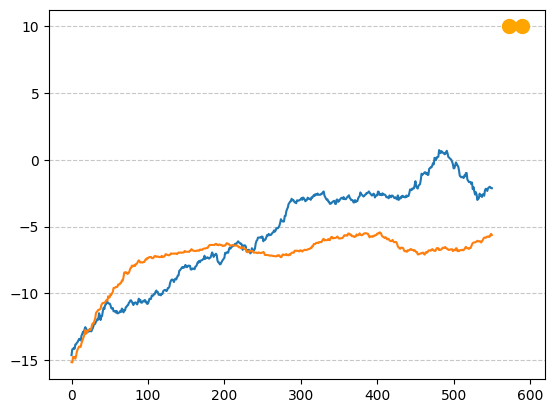

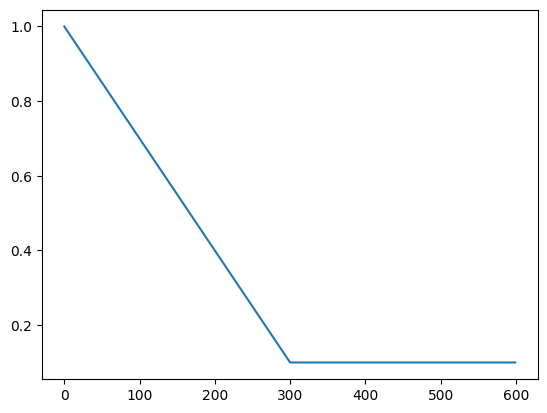

In [ ]:
model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_1, epsilons1 = train(model, epoch=600, gamm=0.99, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_2, epsilons1 = train(model, epoch=600, gamm=0.99, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

plot_progress(results1_1)
plot_progress(results1_2)
plt.show()
plt.plot(epsilons1)

In [24]:
evaluate_catmouse_model(model, episodes=10, render=True, print_qvals=True)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\2544615170.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32)


tensor([-4.7851, -4.9700, -4.9431, -5.0736])
tensor([-4.5600, -4.7207, -4.6797, -4.8074])
tensor([-4.5275, -4.6704, -4.6035, -4.7190])
tensor([-4.4767, -4.6026, -4.5056, -4.6082])
tensor([-4.4337, -4.5309, -4.4055, -4.4815])
tensor([-4.2957, -4.3765, -4.2812, -4.3462])
tensor([-4.1898, -4.2412, -4.1849, -4.2254])
tensor([-4.0955, -4.1129, -4.1018, -4.1153])
tensor([-4.0748, -4.1205, -4.0583, -4.0915])
tensor([-4.0745, -4.0849, -4.0803, -4.0881])
tensor([-4.0895, -4.1283, -4.0768, -4.1046])
tensor([-4.0902, -4.0926, -4.0991, -4.1000])
tensor([-4.1060, -4.1355, -4.0952, -4.1148])
tensor([-4.1229, -4.1168, -4.1344, -4.1269])
tensor([-4.2096, -4.2830, -4.2247, -4.2718])
tensor([-4.2486, -4.3105, -4.2273, -4.2623])
tensor([-4.2953, -4.3276, -4.2970, -4.3070])
tensor([-4.3518, -4.4191, -4.3342, -4.3651])
tensor([-4.3861, -4.4241, -4.3893, -4.3955])
tensor([-4.4262, -4.4974, -4.4156, -4.4453])
tensor([-4.3228, -4.3609, -4.3424, -4.3501])
tensor([-3.9464, -4.0044, -3.9325, -3.9617])
tensor([-3

KeyboardInterrupt: 

due to the reward for begin close to the target the agent just started to circle the target, hacking the reward

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 1000/1000 [00:57<00:00, 17.26it/s]
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\2544615170.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_g

Episode 1: Reward = 15.15724156391091
Episode 2: Reward = -9.397649990231347
Episode 3: Reward = -7.0
Episode 4: Reward = -0.49999999999999645
Episode 5: Reward = 12.100000000000025
Episode 6: Reward = -6.3999999999999995
Episode 7: Reward = -14.653566128533686
Episode 8: Reward = -11.888771760713851
Episode 9: Reward = -18.7501659153438
Episode 10: Reward = -6.7
Average reward over 10 episodes: -4.803291223091175
Average count over 10 episodes: 2.8


100%|██████████| 1000/1000 [01:10<00:00, 14.21it/s]

Episode 1: Reward = -2.299999999999999
Episode 2: Reward = -4.103962476474634
Episode 3: Reward = -2.4
Episode 4: Reward = -3.273917687530602
Episode 5: Reward = -6.599999999999995
Episode 6: Reward = -7.4
Episode 7: Reward = -10.031765981886352
Episode 8: Reward = -6.963890679889564
Episode 9: Reward = 0.3000000000000025
Episode 10: Reward = -0.13640725407691345
Average reward over 10 episodes: -4.290994407985806
Average count over 10 episodes: 1.4
Best run: 18.461764036656803, at episode: 867
Best run: 21.78888929095242, at episode: 620


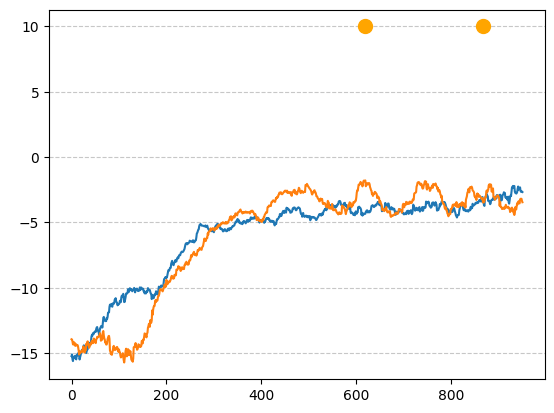

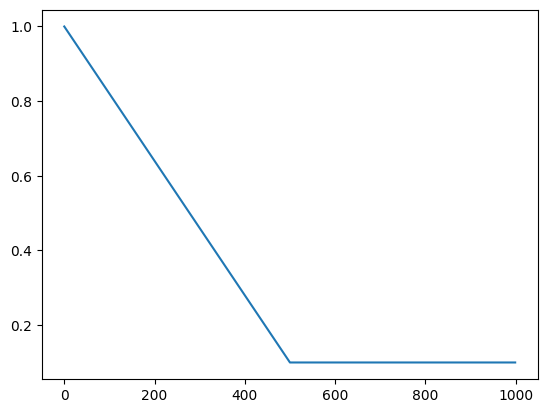

In [25]:
model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_1, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_2, epsilons1 = train(model, epoch=1000, gamm=0.99, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

plot_progress(results1_1)
plot_progress(results1_2)
plt.show()
plt.plot(epsilons1)

In [ ]:
evaluate_catmouse_model(model, episodes=10, render=True, print_qvals=True)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\2544615170.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32)


tensor([2.7317, 2.8221, 2.6228, 2.7561])
tensor([2.7062, 2.7934, 2.6428, 2.7614])
tensor([2.4569, 2.4276, 2.4811, 2.5048])
tensor([2.5241, 2.4502, 2.5264, 2.5274])
tensor([2.6177, 2.4918, 2.5941, 2.5688])
tensor([2.4320, 2.2471, 2.4406, 2.3682])
tensor([2.5595, 2.4055, 2.5413, 2.4951])
tensor([2.2837, 2.1511, 2.3489, 2.2933])
tensor([2.3223, 2.3728, 2.2849, 2.3619])
tensor([2.1738, 2.0379, 2.2608, 2.1981])
tensor([2.1965, 2.2583, 2.1898, 2.2671])
tensor([2.4434, 2.4199, 2.3473, 2.3948])
tensor([2.1572, 2.2389, 2.1708, 2.2584])
tensor([2.4151, 2.4001, 2.3329, 2.3849])
tensor([2.1162, 2.2179, 2.1509, 2.2486])
tensor([2.3725, 2.3777, 2.3122, 2.3742])
tensor([2.2443, 2.0516, 2.3122, 2.2263])
tensor([2.2640, 2.2799, 2.2565, 2.3136])
tensor([2.5209, 2.4395, 2.4329, 2.4504])
tensor([2.2257, 2.2605, 2.2680, 2.3280])
tensor([2.4701, 2.4070, 2.4364, 2.4550])
tensor([2.1676, 2.2203, 2.2667, 2.3269])
tensor([2.3969, 2.3507, 2.4251, 2.4419])
tensor([2.7818, 2.6035, 2.7133, 2.6713])
tensor([2.6573, 

KeyboardInterrupt: 

all 4 q values are very similar, due to high gamma, this makes the agent "confused" it gets stuck at its place due to selecting opposing action constantly

  0%|          | 0/600 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 600/600 [01:19<00:00,  7.52it/s]
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\2544615170.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad

Episode 1: Reward = -10.734392099169607
Episode 2: Reward = -16.465484270984195
Episode 3: Reward = -14.946768529773163
Episode 4: Reward = -25.933359529812968
Episode 5: Reward = 2.3614280091302255
Episode 6: Reward = -13.295683148544375
Episode 7: Reward = -0.4417436459623634
Episode 8: Reward = -14.845188509116205
Episode 9: Reward = -13.265539416831457
Episode 10: Reward = -14.805691827524331
Average reward over 10 episodes: -12.237242296858845
Average count over 10 episodes: 2.6


100%|██████████| 600/600 [01:03<00:00,  9.50it/s]


Episode 1: Reward = -2.9000000000000004
Episode 2: Reward = -23.683759223152624
Episode 3: Reward = -12.662259706772367
Episode 4: Reward = -6.3
Episode 5: Reward = -3.3000000000000007
Episode 6: Reward = -19.54645121978776
Episode 7: Reward = -0.39999999999999325
Episode 8: Reward = -8.035294479504628
Episode 9: Reward = -6.133603603325277
Episode 10: Reward = -9.621861486326829
Average reward over 10 episodes: -9.258322971886946
Average count over 10 episodes: 1.2
Best run: 2.2474471048374234, at episode: 561
Best run: 3.5408578396579564, at episode: 559


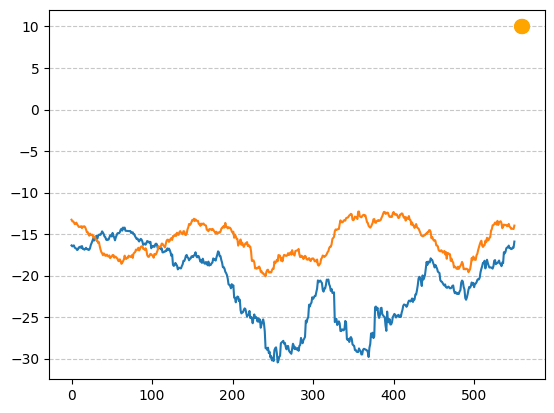

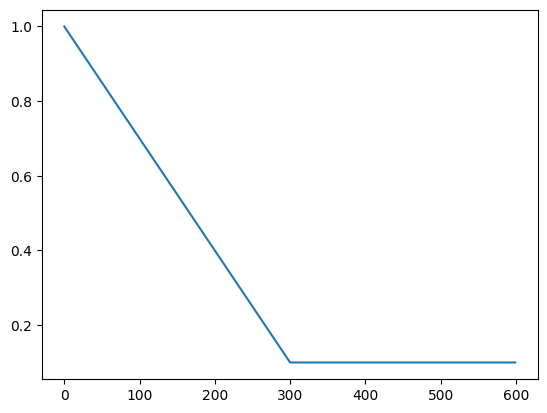

In [28]:
model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_1, epsilons1 = train(model, epoch=600, gamm=0.9, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_2, epsilons1 = train(model, epoch=600, gamm=0.9, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

plot_progress(results1_1)
plot_progress(results1_2)
plt.show()
plt.plot(epsilons1)

In [30]:
evaluate_catmouse_model(model, episodes=10, render=True, print_qvals=True)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\2544615170.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32)


tensor([-0.0825, -0.3175, -0.0402, -0.2798])
tensor([ 0.0855, -0.1336,  0.1499, -0.0902])
tensor([0.3728, 0.1860, 0.4605, 0.2369])
tensor([0.6998, 0.5492, 0.8193, 0.6133])
tensor([1.0669, 0.9584, 1.2300, 1.0438])
tensor([1.4877, 1.4197, 1.6425, 1.4918])
tensor([1.8161, 1.7489, 1.9522, 1.7971])
tensor([2.1704, 2.0999, 2.2762, 2.1134])
tensor([2.5165, 2.4418, 2.5903, 2.4186])
tensor([2.8493, 2.7691, 2.8889, 2.7071])
tensor([3.1568, 3.0692, 3.1585, 2.9647])
tensor([-0.8074, -0.8767, -0.9962, -1.0046])
tensor([-0.2035, -0.2300, -0.2542, -0.2926])
tensor([-0.3365, -0.3481, -0.3724, -0.3870])
tensor([-0.5768, -0.5433, -0.5967, -0.5621])
tensor([-0.7326, -0.6983, -0.7414, -0.7093])
tensor([-1.0398, -1.0290, -1.0049, -0.9935])
tensor([-0.8934, -0.9406, -0.8585, -0.9186])
tensor([-0.8319, -0.8567, -0.7968, -0.8319])
tensor([-0.7524, -0.7639, -0.7269, -0.7458])
tensor([-0.8029, -0.8206, -0.8013, -0.8228])
tensor([-0.9506, -1.0109, -0.9567, -1.0262])
tensor([-1.2230, -1.2509, -1.2113, -1.2454])
t

KeyboardInterrupt: 

reducing gamma further

  0%|          | 0/600 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 600/600 [01:18<00:00,  7.62it/s]
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\2544615170.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad

Episode 1: Reward = -35.85598987804869
Episode 2: Reward = -48.09431637658712
Episode 3: Reward = -21.036641274035368
Episode 4: Reward = -28.106239010570157
Episode 5: Reward = -27.968337647621247
Episode 6: Reward = -47.88443254344614
Episode 7: Reward = -12.836740445747331
Episode 8: Reward = -21.094314877288898
Episode 9: Reward = -20.320647280035914
Episode 10: Reward = -27.244368590805994
Average reward over 10 episodes: -29.044202792418684
Average count over 10 episodes: 0.5


100%|██████████| 600/600 [01:04<00:00,  9.24it/s]


Episode 1: Reward = -25.021816283450434
Episode 2: Reward = -49.976207626109584
Episode 3: Reward = -24.87295541345112
Episode 4: Reward = -42.26812353379623
Episode 5: Reward = -25.369306975909623
Episode 6: Reward = -42.9186299564653
Episode 7: Reward = -11.000179312910094
Episode 8: Reward = -46.3834077148204
Episode 9: Reward = -61.74952765736023
Episode 10: Reward = -64.44007423180821
Average reward over 10 episodes: -39.40002287060813
Average count over 10 episodes: 0.1
Best run: -1.6999999999999993, at episode: 290
Best run: -1.3999999999999995, at episode: 583


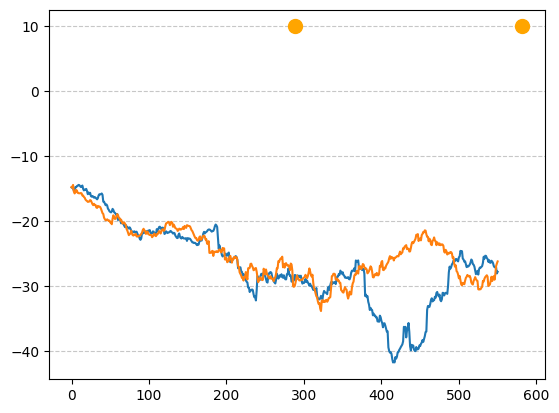

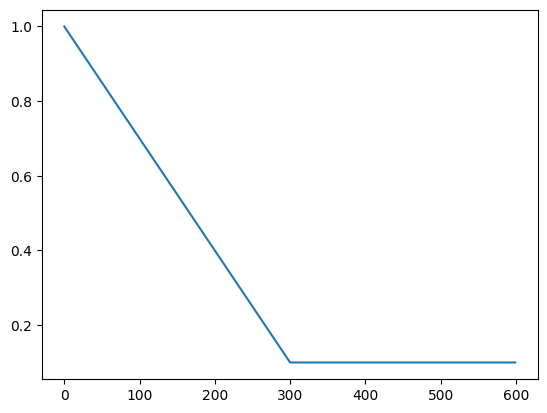

In [31]:
model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_1, epsilons1 = train(model, epoch=600, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_2, epsilons1 = train(model, epoch=600, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

plot_progress(results1_1)
plot_progress(results1_2)
plt.show()
plt.plot(epsilons1)

In [33]:
evaluate_catmouse_model(model, episodes=10, render=True, print_qvals=True)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\2544615170.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32)


tensor([-0.4317, -0.4259, -0.4368, -0.4677])
tensor([-0.4333, -0.4256, -0.4366, -0.4633])
tensor([-0.4316, -0.4215, -0.4330, -0.4537])
tensor([-0.4286, -0.4157, -0.4278, -0.4414])
tensor([-0.4259, -0.4099, -0.4227, -0.4286])
tensor([-0.4850, -0.4682, -0.4706, -0.4898])
tensor([-0.5283, -0.5105, -0.5048, -0.5337])
tensor([-0.5187, -0.5001, -0.4965, -0.5205])
tensor([-0.5034, -0.4844, -0.4841, -0.5025])
tensor([-0.5021, -0.4834, -0.4872, -0.4987])
tensor([-0.5537, -0.5341, -0.5255, -0.5542])
tensor([-0.5331, -0.5136, -0.5095, -0.5314])
tensor([-0.5110, -0.4919, -0.4928, -0.5078])
tensor([-0.5805, -0.5611, -0.5500, -0.5816])
tensor([-0.5425, -0.5246, -0.5228, -0.5429])
tensor([-0.5419, -0.5275, -0.5286, -0.5511])
tensor([-0.7562, -0.6594, -0.5293, -0.5212])
tensor([-0.7991, -0.7075, -0.5749, -0.5675])
tensor([-0.7639, -0.7138, -0.6346, -0.6494])
tensor([-0.7109, -0.6790, -0.6284, -0.6558])
tensor([-0.6231, -0.6166, -0.6086, -0.6588])
tensor([-0.6320, -0.6149, -0.5920, -0.6364])
tensor([-0

KeyboardInterrupt: 

maybe due to low gamma the +5 for the apple is too low after being discounted too much <br>
increasing the death, target reawrds to -50, +50 from -5, +5

In [39]:
model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_1, epsilons1 = train(model, epoch=600, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_2, epsilons1 = train(model, epoch=600, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

plot_progress(results1_1)
plot_progress(results1_2)
plt.show()
plt.plot(epsilons1)

  0%|          | 0/600 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 600/600 [01:10<00:00,  8.51it/s]
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\2544615170.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad

Episode 1: Reward = -98.88806943416535
Episode 2: Reward = -65.19043229306084
Episode 3: Reward = -72.62432410328425
Episode 4: Reward = -63.15068327801829
Episode 5: Reward = -63.716331880981684


KeyboardInterrupt: 

In [40]:
evaluate_catmouse_model(model, episodes=10, render=True, print_qvals=True)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\2544615170.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32)


tensor([ 0.1065,  0.0812, -0.1200,  0.0434])
tensor([ 0.0687,  0.0428, -0.1495,  0.0605])
tensor([ 0.0337,  0.0064, -0.1761,  0.0861])
tensor([-0.0114, -0.0307, -0.2226,  0.0237])
tensor([-0.0585, -0.0695, -0.2714, -0.0465])
tensor([-0.1082, -0.1101, -0.3230, -0.1248])
tensor([-0.1465, -0.1488, -0.3534, -0.1132])
tensor([-0.1915, -0.1850, -0.4011, -0.1877])
tensor([-0.2569, -0.2494, -0.4551, -0.1980])
tensor([-0.2673, -0.2519, -0.4751, -0.2533])
tensor([-0.3351, -0.3185, -0.5314, -0.2717])
tensor([-0.3477, -0.3232, -0.5534, -0.3341])
tensor([-0.4038, -0.3789, -0.5991, -0.3471])
tensor([-0.4050, -0.3729, -0.6107, -0.4017])
tensor([-0.4604, -0.4283, -0.6551, -0.4120])
tensor([-0.4622, -0.4231, -0.6667, -0.4660])
tensor([-0.5176, -0.4788, -0.7106, -0.4751])
tensor([-0.5202, -0.4745, -0.7228, -0.5294])
tensor([-0.5759, -0.5307, -0.7667, -0.5382])
tensor([-0.6198, -0.5766, -0.7992, -0.5317])
tensor([-0.6167, -0.5679, -0.8048, -0.5754])
tensor([-0.6827, -0.6357, -0.8539, -0.5837])
tensor([-0

KeyboardInterrupt: 

agent is too afraid of dying, not going for rewards, goes in a neverending loop avoiding the chaser

changed caught reward from -50 to -20

  0%|          | 0/600 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 600/600 [01:12<00:00,  8.26it/s]
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3255415186.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad

Episode 1: Reward = -41.71830776634479
Episode 2: Reward = -21.3
Episode 3: Reward = -47.05750419979181
Episode 4: Reward = -45.26352382162865
Episode 5: Reward = 6.460876658779682
Episode 6: Reward = -11.457837378957468
Episode 7: Reward = -53.54578579337955
Episode 8: Reward = -29.52760940158086
Episode 9: Reward = -41.66055734315005
Episode 10: Reward = -40.56308977915892
Average reward over 10 episodes: -32.56333388252124
Average count over 10 episodes: 0.2


100%|██████████| 600/600 [01:14<00:00,  8.06it/s]


Episode 1: Reward = -39.2472705187982
Episode 2: Reward = 56.30414983924119
Episode 3: Reward = -46.262710475179865
Episode 4: Reward = 12.924360639533653
Episode 5: Reward = -37.62454007135859
Episode 6: Reward = -44.695121120524895
Episode 7: Reward = -40.2744075759107
Episode 8: Reward = -12.092434593111518
Episode 9: Reward = 9.727102139532725
Episode 10: Reward = -52.3502138739882
Average reward over 10 episodes: -19.359108561056438
Average count over 10 episodes: 0.5
Best run: 144.74591777689113, at episode: 438
Best run: 148.045921458639, at episode: 586


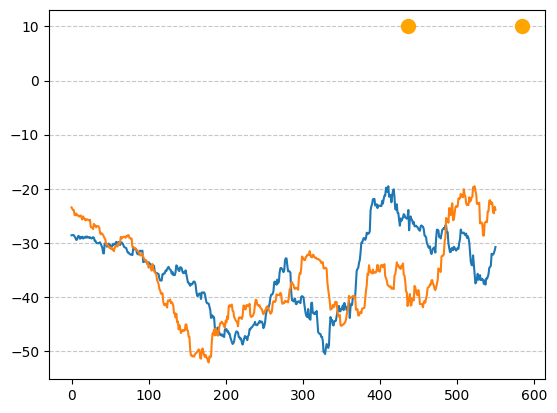

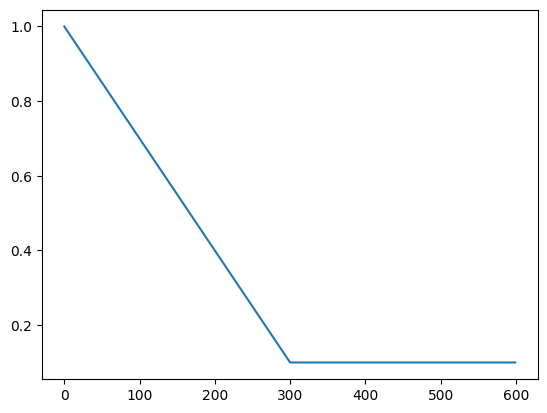

In [49]:
model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_1, epsilons1 = train(model, epoch=600, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_2, epsilons1 = train(model, epoch=600, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

plot_progress(results1_1)
plot_progress(results1_2)
plt.show()
plt.plot(epsilons1)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 1000/1000 [01:51<00:00,  8.94it/s]
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3255415186.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_g

Episode 1: Reward = -29.00732427600382
Episode 2: Reward = -61.518123192734876
Episode 3: Reward = -80.6549879387119
Episode 4: Reward = -33.941529970538866
Episode 5: Reward = 10.698445134657405
Episode 6: Reward = -36.57992722097204
Episode 7: Reward = -42.52232978540161
Episode 8: Reward = -36.13000985760534
Episode 9: Reward = -32.26414471119964
Episode 10: Reward = -52.19978743032577
Average reward over 10 episodes: -39.411971924883645
Average count over 10 episodes: 0.2


100%|██████████| 1000/1000 [02:22<00:00,  7.01it/s]


Episode 1: Reward = -76.44178298519245
Episode 2: Reward = -42.48741023161738
Episode 3: Reward = -57.75153167889279
Episode 4: Reward = -44.975862923882
Episode 5: Reward = -41.73658503171188
Episode 6: Reward = -42.24939742982285
Episode 7: Reward = -65.24577618455345
Episode 8: Reward = -35.62645394676449
Episode 9: Reward = -72.5215261325416
Episode 10: Reward = -37.36406446810946
Average reward over 10 episodes: -51.640039101308844
Average count over 10 episodes: 0.1
Best run: 54.33363427619884, at episode: 553
Best run: 182.7051499862495, at episode: 463


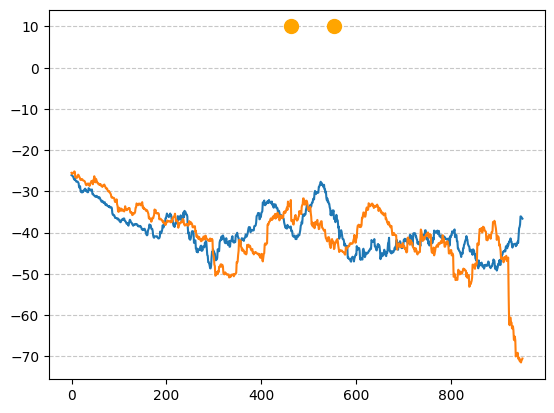

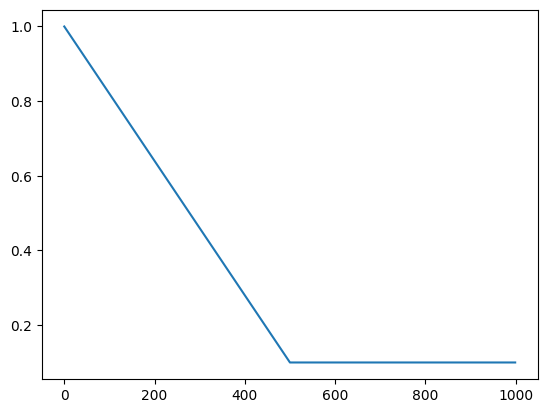

In [51]:
model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_1, epsilons1 = train(model, epoch=1000, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_2, epsilons1 = train(model, epoch=1000, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

plot_progress(results1_1)
plot_progress(results1_2)
plt.show()
plt.plot(epsilons1)

In [52]:
evaluate_catmouse_model(model, episodes=10, render=True, print_qvals=True)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3255415186.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32)


tensor([-0.3621, -0.2685, -0.3267, -0.3660])
tensor([-0.4278, -0.3603, -0.3402, -0.4052])
tensor([-0.3532, -0.2537, -0.3493, -0.3763])
tensor([-0.4196, -0.3466, -0.3631, -0.4160])
tensor([-0.5002, -0.4623, -0.3836, -0.4711])
tensor([-0.4399, -0.3786, -0.3996, -0.4578])
tensor([-0.5229, -0.4980, -0.4197, -0.5141])
tensor([-0.4639, -0.4163, -0.4355, -0.5014])
tensor([-0.5493, -0.5392, -0.4552, -0.5588])
tensor([-0.4915, -0.4595, -0.4707, -0.5467])
tensor([-0.5791, -0.5859, -0.4899, -0.6051])
tensor([-0.5225, -0.5079, -0.5052, -0.5935])
tensor([-0.4490, -0.4029, -0.5143, -0.5653])
tensor([-0.5217, -0.5052, -0.5275, -0.6081])
tensor([-0.6136, -0.6378, -0.5468, -0.6688])
tensor([-0.5595, -0.5635, -0.5621, -0.6586])
tensor([-0.5123, -0.4969, -0.6165, -0.6787])
tensor([-0.6254, -0.6506, -0.5675, -0.7212])
tensor([-0.5878, -0.5966, -0.6207, -0.7352])
tensor([-0.5300, -0.5546, -0.4593, -0.6495])
tensor([-1.1667, -0.6108, -1.3743, -0.7532])
tensor([-0.8299, -0.5853, -1.1381, -0.8745])
tensor([-0

KeyboardInterrupt: 

the q value problem is fixed but still it does not go towards the target, it is too dumb to learn without the reward for being close to the target

  0%|          | 0/600 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 600/600 [00:58<00:00, 10.33it/s]
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3255415186.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad

Episode 1: Reward = -16.584162021184582
Episode 2: Reward = 59.88269237484555
Episode 3: Reward = 153.24530122100063
Episode 4: Reward = -47.321972949637
Episode 5: Reward = 17.078635505242673
Episode 6: Reward = -2.844665499171878
Episode 7: Reward = 325.27743153364423
Episode 8: Reward = 8.016278962334333
Episode 9: Reward = 3.6502626595022782
Episode 10: Reward = 1.4288864994564925
Average reward over 10 episodes: 50.182868828603276
Average count over 10 episodes: 1.2


100%|██████████| 600/600 [01:10<00:00,  8.57it/s]


Episode 1: Reward = 38.44446363582959
Episode 2: Reward = 188.64886692465217
Episode 3: Reward = -9.60051074613161
Episode 4: Reward = 115.37968231991739
Episode 5: Reward = 62.13390022073075
Episode 6: Reward = 69.39237647436018
Episode 7: Reward = -70.87916463919177
Episode 8: Reward = 153.10346928010335
Episode 9: Reward = 286.3909599388852
Episode 10: Reward = -29.179286290974893
Average reward over 10 episodes: 80.38347571181804
Average count over 10 episodes: 2.1
Best run: 402.43927491206705, at episode: 251
Best run: 790.8010859602088, at episode: 519


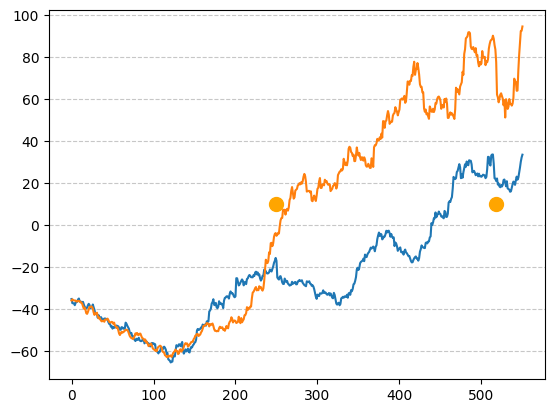

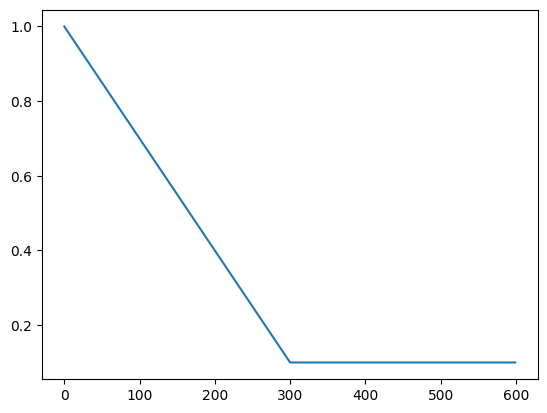

In [55]:
model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_1, epsilons1 = train(model, epoch=600, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_2, epsilons1 = train(model, epoch=600, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

plot_progress(results1_1)
plot_progress(results1_2)
plt.show()
plt.plot(epsilons1)

In [62]:
evaluate_catmouse_model(model, episodes=100, render=False)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3255415186.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32)


Episode 1: Reward = 115.81420314262851
Episode 2: Reward = -100.48108151897443
Episode 3: Reward = 37.25995790649632
Episode 4: Reward = -11.975497848573928
Episode 5: Reward = -0.6718850518412722
Episode 6: Reward = 54.57939168702667
Episode 7: Reward = 201.62098956297132
Episode 8: Reward = 55.818258830925245
Episode 9: Reward = 65.5733685849869
Episode 10: Reward = -65.84727882761186
Episode 11: Reward = -5.551062400278196
Episode 12: Reward = -19.793389413860364
Episode 13: Reward = -17.766769640197687
Episode 14: Reward = 280.76302672153645
Episode 15: Reward = -37.46614653282862
Episode 16: Reward = -13.257097986754335
Episode 17: Reward = 534.966498022337
Episode 18: Reward = 490.10536169650203
Episode 19: Reward = -15.585948483770249
Episode 20: Reward = -19.31227894956361
Episode 21: Reward = 110.72224559501124
Episode 22: Reward = 104.26304470601858
Episode 23: Reward = 184.74471787016338
Episode 24: Reward = 430.28115598531275
Episode 25: Reward = -137.61113972268987
Episode

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 1000/1000 [02:01<00:00,  8.24it/s]
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3255415186.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_g

Episode 1: Reward = -27.184619214963273
Episode 2: Reward = 86.47530050773494
Episode 3: Reward = -26.155552856549146
Episode 4: Reward = 53.99292677597489
Episode 5: Reward = 97.66007399768543
Episode 6: Reward = 148.3424362301216
Episode 7: Reward = 36.841117921995114
Episode 8: Reward = 93.29251572727406
Episode 9: Reward = 17.634636958420725
Episode 10: Reward = 71.0286214400403
Average reward over 10 episodes: 55.192745748773476
Average count over 10 episodes: 1.6


100%|██████████| 1000/1000 [02:32<00:00,  6.56it/s]


Episode 1: Reward = 686.3899734454913
Episode 2: Reward = 195.74396746288141
Episode 3: Reward = 142.9239387826428
Episode 4: Reward = 437.54138725317887
Episode 5: Reward = 339.6486997453787
Episode 6: Reward = 629.5770092110531
Episode 7: Reward = 1139.5335312680936
Episode 8: Reward = -48.36574988964243
Episode 9: Reward = 971.6936222605059
Episode 10: Reward = -58.554666067682845
Average reward over 10 episodes: 443.61317134719013
Average count over 10 episodes: 8.5
Best run: 1085.025121937945, at episode: 593
Best run: 1539.2179979582108, at episode: 731


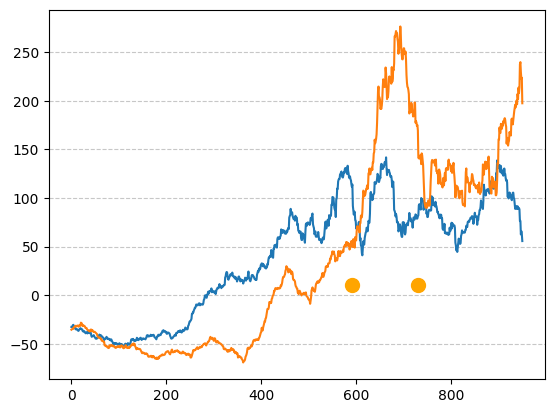

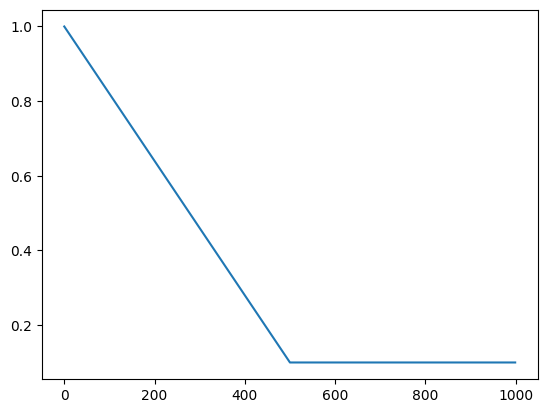

In [63]:
model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_1, epsilons1 = train(model, epoch=1000, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

model = torch.nn.Sequential(    torch.nn.Linear(10, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 12),    torch.nn.ReLU(),    torch.nn.Linear(12, 4))
results1_2, epsilons1 = train(model, epoch=1000, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

plot_progress(results1_1)
plot_progress(results1_2)
plt.show()
plt.plot(epsilons1)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_states[index] = torch.tensor(state, dtype=torch.float)
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3142645502.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.buffer_nextstates[index] = torch.tensor(next_state, dtype=torch.float)
100%|██████████| 1000/1000 [02:54<00:00,  5.73it/s]
C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3255415186.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_g

Episode 1: Reward = 53.69286698152451
Episode 2: Reward = 324.326386369027
Episode 3: Reward = 455.8996003758346
Episode 4: Reward = 31.545187820252085
Episode 5: Reward = 146.70987480701143
Episode 6: Reward = 582.1628601941042
Episode 7: Reward = -23.132564472620817
Episode 8: Reward = 243.5983310744508
Episode 9: Reward = 549.0751241993082
Episode 10: Reward = 85.13244741059395
Average reward over 10 episodes: 244.9010114759486
Average count over 10 episodes: 5.2


100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


Episode 1: Reward = -13.166279557438777
Episode 2: Reward = -16.73891084763157
Episode 3: Reward = 311.4953654336101
Episode 4: Reward = 31.22495955113894
Episode 5: Reward = 90.93895975083238
Episode 6: Reward = 266.54324656245313
Episode 7: Reward = 41.44343666346974
Episode 8: Reward = 150.21089207826455
Episode 9: Reward = -61.60840624848061
Episode 10: Reward = 10.795482717751735
Average reward over 10 episodes: 81.11387461039696
Average count over 10 episodes: 2.0
Best run: 2752.305842468054, at episode: 626
Best run: 2208.0876668582273, at episode: 958


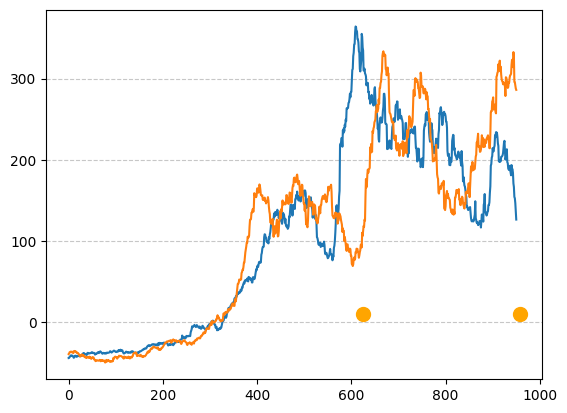

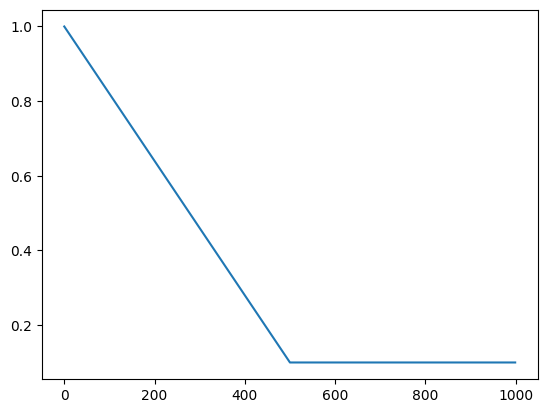

In [66]:
model = torch.nn.Sequential(    torch.nn.Linear(10, 16),    torch.nn.ReLU(),    torch.nn.Linear(16, 32),    torch.nn.ReLU(),    torch.nn.Linear(32, 16), torch.nn.ReLU(),    torch.nn.Linear(16, 4))
results1_1, epsilons1 = train(model, epoch=1000, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

model = torch.nn.Sequential(    torch.nn.Linear(10, 16),    torch.nn.ReLU(),    torch.nn.Linear(16, 32),    torch.nn.ReLU(),    torch.nn.Linear(32, 16), torch.nn.ReLU(),    torch.nn.Linear(16, 4))
results1_2, epsilons1 = train(model, epoch=1000, gamm=0.8, lrate=0.001)
evaluate_catmouse_model(model, print_qvals=False, render=False, episodes=10)

plot_progress(results1_1)
plot_progress(results1_2)
plt.show()
plt.plot(epsilons1)

In [70]:
torch.save(model.state_dict(), "chaser_mid_model")

In [71]:
model = torch.nn.Sequential(
    torch.nn.Linear(10, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 4)
)
model.load_state_dict(torch.load("chaser_mid_model"))
model.eval()

Sequential(
  (0): Linear(in_features=10, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=4, bias=True)
)

In [73]:
evaluate_catmouse_model(model, episodes=100, render=True, print_qvals=True)

C:\Users\ADITYA UJJWAL\AppData\Local\Temp\ipykernel_9328\3255415186.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(obs, dtype=torch.float32)


tensor([-2.0579, -1.5814, -2.3378, -1.7881])
tensor([-1.9267, -1.5349, -2.1818, -1.7240])
tensor([-1.7606, -1.4386, -1.9936, -1.6133])
tensor([-1.5973, -1.3183, -1.8153, -1.4847])
tensor([-1.2329, -1.0445, -1.4158, -1.1883])
tensor([-0.9235, -0.8296, -1.0790, -0.9636])
tensor([-0.5695, -0.4486, -0.7267, -0.5988])
tensor([-0.1070,  0.0417, -0.2610, -0.1211])
tensor([0.4373, 0.5943, 0.2604, 0.3746])
tensor([1.2253, 1.3306, 0.9436, 0.9163])
tensor([1.9714, 2.0815, 1.4379, 1.3784])
tensor([2.5886, 2.8161, 1.6206, 1.7086])
tensor([2.8899, 2.9083, 1.9063, 1.8473])
tensor([3.2023, 3.0229, 2.1928, 2.0021])
tensor([3.6294, 3.8568, 2.4360, 2.7779])
tensor([4.0865, 3.8515, 2.9352, 2.8568])
tensor([4.5623, 4.6220, 3.2295, 3.5841])
tensor([5.6892, 5.1103, 4.5246, 4.1850])
tensor([6.8287, 6.4350, 5.7023, 5.6276])
tensor([7.4803, 7.7191, 6.1817, 6.8040])
tensor([9.3672, 8.7274, 8.3499, 8.0188])
tensor([10.9380, 11.0168,  9.7821, 10.1921])
tensor([14.5245, 13.4856, 13.8896, 13.0676])
tensor([18.1566, 

KeyboardInterrupt: 